In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize, SymLogNorm
from matplotlib import cm as colormap
import time
from string import ascii_lowercase

# SimPEG, discretize/
import discretize
from discretize import utils
from SimPEG.electromagnetics import time_domain as tdem
from SimPEG.electromagnetics import resistivity as dc
from SimPEG.utils import mkvc, plot_1d_layer_model
from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

from pymatsolver import Pardiso

<AxesSubplot: xlabel='x', ylabel='z'>

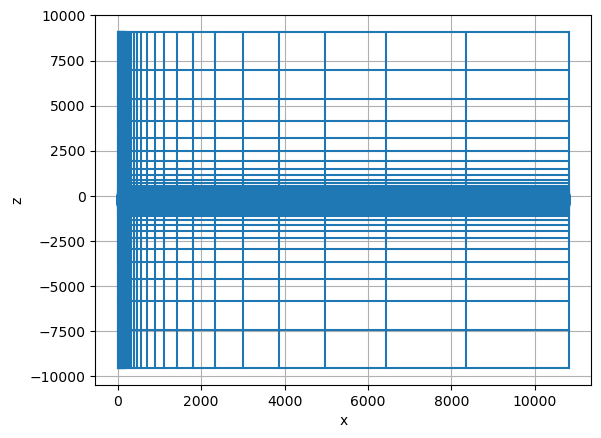

In [2]:
csx = 10
csz = 5
pf = 1.3

ncx = 15
ncz = int(500/csz)
ncza = 12
npadx = 21
npadz = 23

mesh = discretize.CylindricalMesh(
    [[(csx, ncx), (csx, npadx, pf)], [np.pi*2], [(csz, npadz, -pf), (csz, ncz+ncza), (csz, npadz, pf)]], 
    origin = "000"
)
mesh.origin = np.r_[0, 0, -mesh.h[2][:npadz+ncz].sum()]
mesh.plot_grid()

In [3]:
rho_back = 100
sigma_target = np.r_[1./rho_back, 0.1, 1, 10, 100]
target_radius = np.r_[0, np.inf]
target_t = 30
target_z = -150+ target_t/2 * np.r_[-1, 1]
sigma_air = 1e-8

tx_height = 30
tx_radius = 10

def diffusion_distance(sigma, t):
    return 1260 * np.sqrt(t/sigma)

In [4]:
rx_times = np.logspace(np.log10(2e-5), np.log10(8e-3), 20)
diffusion_distance(1./rho_back, rx_times[-1])

1126.9782606598942

In [5]:
models = {}
for sig in sigma_target:
    
    key = f"sigma_{sig:1.0e}"
    
    m = sigma_air * np.ones(mesh.n_cells)
    m[mesh.cell_centers[:, 2] < 0] = 1./rho_back
    
    inds_target = (
        (mesh.cell_centers[:, 0] < target_radius.max()) &
        (mesh.cell_centers[:, 0] > target_radius.min()) &
        (mesh.cell_centers[:, 2] < target_z.max()) &
        (mesh.cell_centers[:, 2] > target_z.min()) 
    )
    m[inds_target] = sig
    models[key] = m

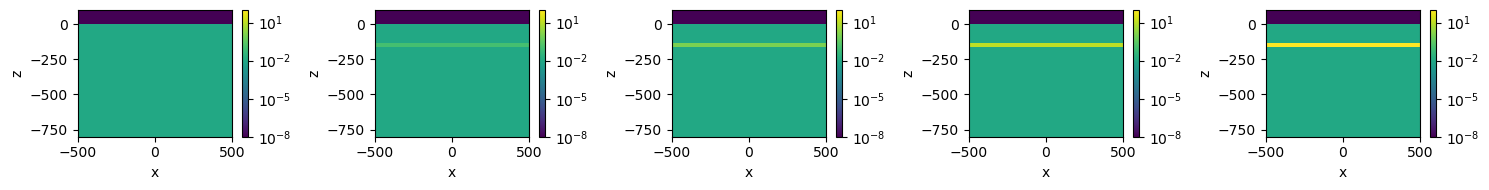

In [6]:
fig, ax = plt.subplots(1, len(models), figsize=(3*len(models), 2))

xlim = 500*np.r_[-1, 1]
zlim = np.r_[-800, 100]

for i, key in enumerate(models.keys()):
    plt.colorbar(mesh.plot_image(
        models[key], ax=ax[i], 
        pcolor_opts={"norm":LogNorm(vmin=sigma_air, vmax=sigma_target.max())},
        mirror=True
    )[0], ax=ax[i])
    ax[i].set_xlim(xlim)
    ax[i].set_ylim(zlim)
    
plt.tight_layout()

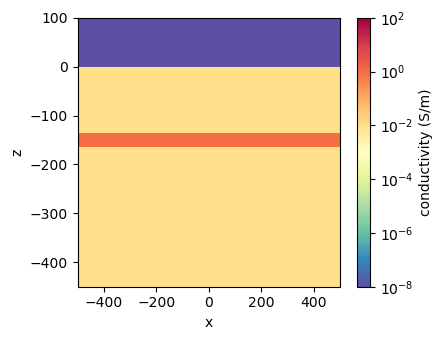

In [146]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.5))

xlim = 500*np.r_[-1, 1]
zlim = np.r_[-450, 100]

key = "sigma_1e+00"
cb = plt.colorbar(mesh.plot_image(
    models[key], ax=ax, 
    pcolor_opts={"norm":LogNorm(vmin=sigma_air, vmax=1e2), "cmap":"Spectral_r"},
    mirror=True
)[0], ax=ax)
ax.set_xlim(xlim)
ax.set_ylim(zlim)
cb.set_label("conductivity (S/m)")
    
plt.tight_layout()

## simulation

In [7]:
waveform=tdem.sources.StepOffWaveform()
# waveform=tdem.sources.VTEMWaveform()

rx_z = tdem.receivers.PointMagneticFluxTimeDerivative(
    np.r_[0, 0, tx_height], times=rx_times, orientation="z"
)

src = tdem.sources.CircularLoop(
    location=np.r_[0, 0, tx_height], radius=tx_radius, receiver_list=[rx_z], waveform=waveform
)

survey = tdem.Survey([src])

In [8]:
# waveform.peak_time/1e-4

In [124]:
time_steps = [
    # (1e-4, np.floor(waveform.peak_time/1e-4)), 
    # (1e-5, np.floor((waveform.off_time-waveform.peak_time)/1e-5)), 
    (1e-5, 40), (3e-5, 20), (1e-4, 20), (3e-4, 20)
]

In [10]:
sim = tdem.simulation.Simulation3DElectricField(
    mesh=mesh, survey=survey, time_steps=time_steps, solver=Pardiso,
    sigmaMap=maps.IdentityMap(mesh)
)

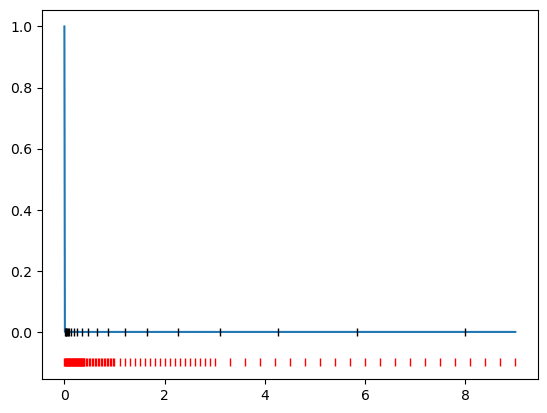

In [11]:
fig, ax = plt.subplots(1,1)
ax.plot(sim.times*1e3, [waveform.eval(t) for t in sim.times])
ax.plot((rx_times+waveform.off_time)*1e3, np.zeros_like(rx_times), "|k")
ax.plot(sim.times*1e3, -0.1*np.ones_like(sim.times), "|r")

In [12]:
fields = {}
dpred = {}

for key, val in models.items():
    t = time.time()
    fields[key] = sim.fields(val)
    dpred[key] = sim.dpred(val, f=fields[key])
    print(f"done {key}... {time.time() - t: 1.2e}s")


done sigma_1e-02...  3.50e+00s
done sigma_1e-01...  8.59e-01s
done sigma_1e+00...  1.13e+00s
done sigma_1e+01...  1.01e+00s
done sigma_1e+02...  9.95e-01s


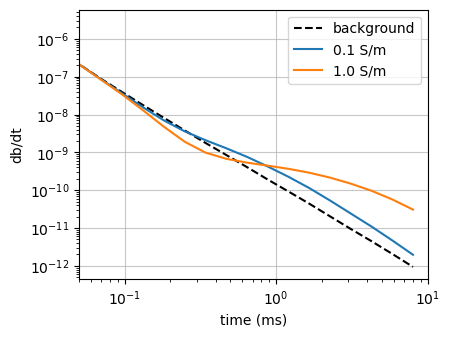

In [134]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.5))
highlight = None
for i, key in enumerate(list(dpred.keys())[:3]):
    val = dpred[key]
    if i == 0: 
        color = "--k"
        label="background"
    else:
        color = f"C{i-1}"
        label = f"{float(key.split('_')[-1]):1.1f} S/m"
    ax.loglog(rx_times*1e3, -val, color, label=label, alpha=1 if highlight == i or highlight is None else 0.2)

ax.set_xlim(5e-2, 10)
# ax.set_ylim(1e-14, 4e-10)
ax.legend()
ax.set_xlabel("time (ms)")
ax.set_ylabel("db/dt")
ax.grid(alpha=0.7)

In [126]:
dpred1d = {}

for i, sig in enumerate(sigma_target):
    key = f"sigma_{sig:1.0e}"
    dpred1d[key] = sim1d_true.dpred(np.log(np.r_[1./rho_back, sig, 1./rho_back]))

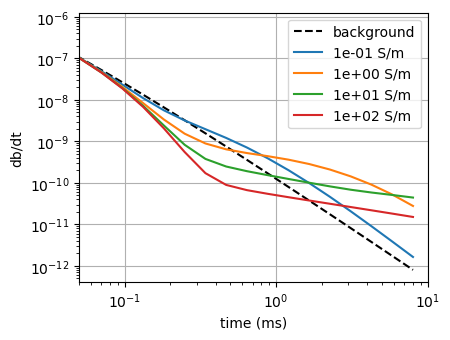

In [128]:
m_true = np.log(np.r_[1./rho_back, 0.1, 1./rho_back])
sim1d_true = tdem.Simulation1DLayered(
    survey=tdem.Survey([src]), thicknesses=np.r_[-target_z.max(), np.diff(target_z)], sigmaMap=maps.ExpMap(nP=3)
)

fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.5))
highlight = None

for i, key in enumerate(dpred1d.keys()):
    val = dpred1d[key]
    if i == 0: 
        color = "--k"
        label="background"
    else:
        color = f"C{i-1}"
        label = f"{key.split('_')[-1]} S/m"
    ax.loglog(rx_times*1e3, -val, color, label=label, alpha=1 if highlight == i or highlight is None else 0.2)

ax.set_xlim(5e-2, 10)
# ax.set_ylim(1e-14, 4e-10)
ax.legend()
ax.set_xlabel("time (ms)")
ax.set_ylabel("db/dt")
ax.grid()




In [14]:
def plot_current_density(
    key, ti, ax=None, xlim = 500*np.r_[-1, 1], zlim=np.r_[-500, 80],
    colorbar=False, ylabels=True, vmax=None
):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    jplt = mesh.average_edge_y_to_cell * fields[key][:, "j", ti]
    
    if vmax is not None: 
        pcolor_opts={"norm":Normalize(vmin=-vmax, vmax=vmax), "cmap":"coolwarm"}
    else: 
        pcolor_opts = {"cmap":"coolwarm"}
    out = mesh.plot_image(
        jplt, ax=ax, 
        mirror=True, mirror_data = -jplt,
        pcolor_opts=pcolor_opts
    )
    
    ax.plot(np.r_[0], tx_height, "ko", ms=2)
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
    ax.set_aspect(1)
    
    if colorbar is True: 
        cb = plt.colorbar(out[0], ax=ax, orientation="horizontal")
        cb.set_label("current density")
    
    time_label = (sim.times[ti]-waveform.off_time)*1e3
    
    if ylabels is False: 
        ax.set_ylabel("")
        ax.set_yticklabels("")
        
    if time_label > 0.99: 
        ax.set_title(f"t={time_label:1.1f} ms")
    else: 
        ax.set_title(f"t={time_label:1.2f} ms")

    return out                         



In [210]:
def plot_dbdt(
    key, ti, ax=None, xlim = 500*np.r_[-1, 1], zlim = np.r_[-500, 80],
    colorbar=False, ylabels=True, vmax=1e-6, vmin=1e-12
):
    dbdtplt = mesh.average_face_to_cell_vector * fields[key][:, "dbdt", ti]
    out = mesh.plot_image(
        dbdtplt, "CCv", view="vec", ax=ax, 
        mirror=True,
        pcolor_opts={"norm":LogNorm(vmin=vmin, vmax=vmax)},
        range_x=xlim, 
        range_y=zlim,
        stream_threshold=vmin
    )
    ax.plot(np.r_[0], tx_height, "ko", ms=2)
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
    ax.set_aspect(1)
    if ylabels is False: 
        ax.set_ylabel("")
        ax.set_yticklabels("")
    if colorbar is True: 
        cb = plt.colorbar(out[0], ax=ax, orientation="horizontal")
        cb.set_label("db/dt")

In [16]:
from matplotlib import animation, collections

In [17]:
times = np.where(sim.times > waveform.off_time-1e-6)[0]
times

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100])

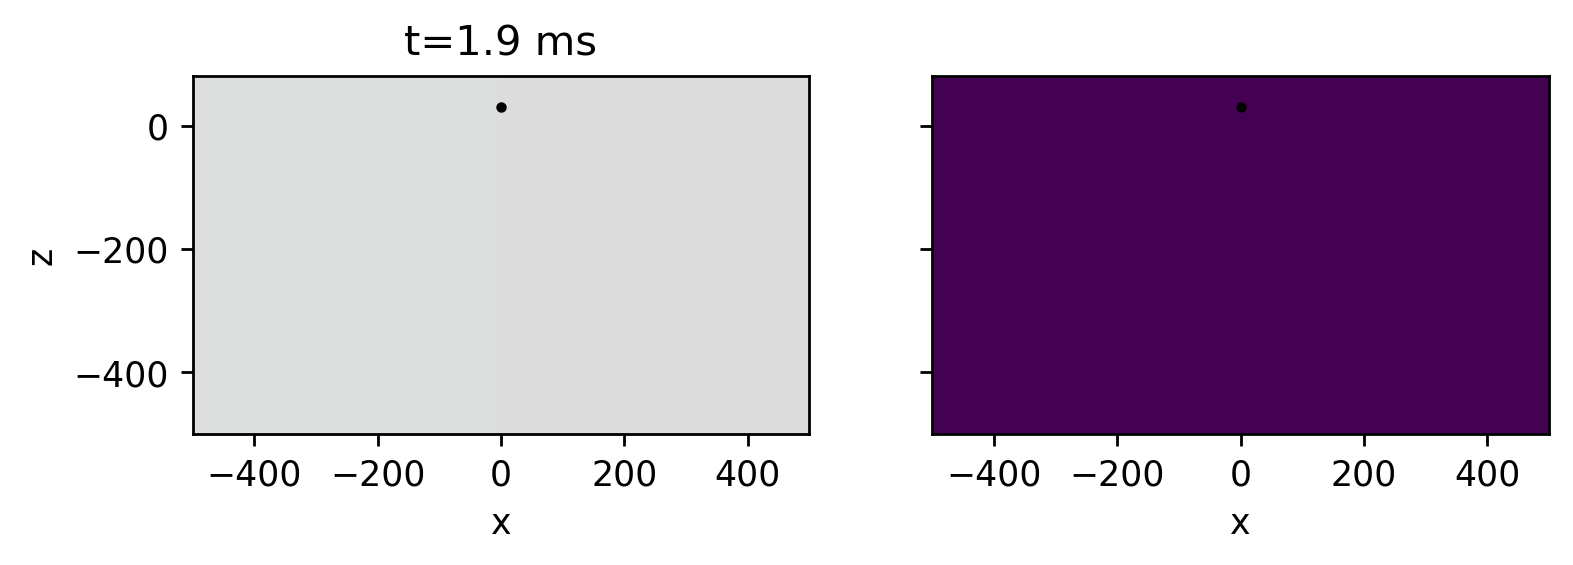

In [269]:
key = "sigma_1e-02"

times = np.where(sim.times*1e3 < 2)[0]
ims = []
fig, ax = plt.subplots(1, 2, figsize=(7, 2), dpi=250)

def plotme(key, ti): 
    outj = plot_current_density(key, ti, ax=ax[0], vmax=2e-7)
    outdbdt = plot_dbdt(key, ti, ax=ax[1], ylabels=False, vmin=6e-11, vmax=3e-7)
    
    return np.hstack([outj, outdbdt])

out = plotme(key, 0)


def init():
    [o.set_array(None) for o in out if isinstance(o, collections.QuadMesh)]
    return out

def update(t):
    for a in ax: 
        a.clear()
    return plotme(key, t)

ani = animation.FuncAnimation(fig, update, times, init_func=init, blit=False)

ani.save(
    f"./geotech-videos/currents_{key}.mp4", writer="ffmpeg", fps=3, bitrate=0, 
    metadata={"title":f"TDEM {key} currents", "artist":"Lindsey Heagy"}
)


In [242]:
# plot_times = [79, 80, 89, 119, 144]
# plot_times = [177, 178, 187, 248, 280]
plot_times = [1, 10, 20, 60]
(sim.times[plot_times] - waveform.off_time)*1e3 

array([0.01, 0.1 , 0.2 , 1.  ])

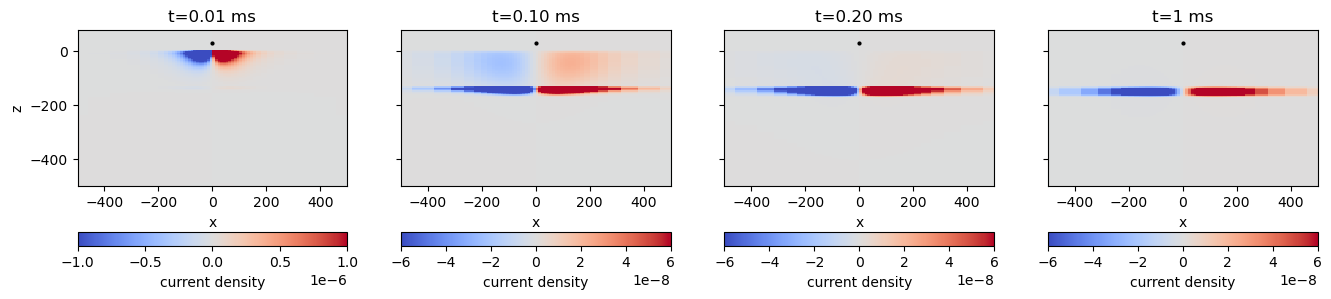

In [272]:
key = "sigma_1e+00"

fig, ax = plt.subplots(1, len(plot_times), figsize=(4*len(plot_times), 4))
xlim = 500*np.r_[-1, 1]
zlim = np.r_[-500, 80]
# vmax = [1e-6, 3e-8, 2e-8, 3e-9]
vmax = [1e-6, 6e-8, 6e-8, 6e-8]

for i, ti in enumerate(plot_times): 
    out = plot_current_density(key, ti, ax=ax[i], vmax=vmax[i], colorbar=True)
    
    time_label = (sim.times[ti]-waveform.off_time)*1e3
    if time_label > 0.9: 
        ax[i].set_title(f"t={time_label:1.0f} ms")
    else: 
        ax[i].set_title(f"t={time_label:1.2f} ms")
    if i > 0:
        ax[i].set_ylabel("")
        ax[i].set_yticklabels("")
        
        

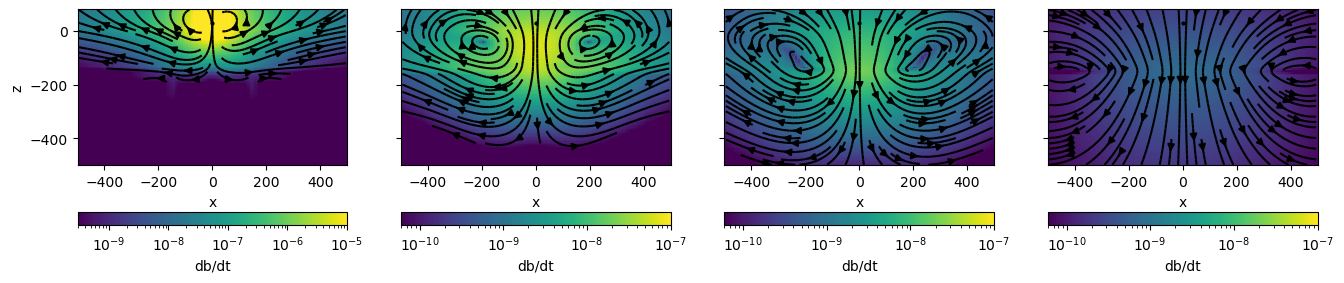

In [262]:
fig, ax = plt.subplots(1, len(plot_times), figsize=(4*len(plot_times), 4))
xlim = 500*np.r_[-1, 1]
zlim = np.r_[-500, 80]

vmax=[1e-5, 1e-7, 1e-7, 1e-7]
vmin=[3e-10, 6e-11, 6e-11, 6e-11]

for i, ti in enumerate(plot_times): 
    dbdtplt = mesh.average_face_to_cell_vector * fields[key][:, "dbdt", ti]
    plot_dbdt(key, ti, ax=ax[i], vmax=vmax[i], vmin=vmin[i], colorbar=True)
    
    time_label = (sim.times[ti]-waveform.off_time)*1e3
    # if time_label > 0.9: 
    #     ax[i].set_title(f"t={time_label:1.0f} ms")
    # else: 
    #     ax[i].set_title(f"t={time_label:1.2f} ms")
    if i > 0:
        ax[i].set_ylabel("")
        ax[i].set_yticklabels("")
        
        

In [60]:
key = "sigma_1e-01"
data_invert = data.Data(survey, dobs=dpred[key], relative_error=0.02)

In [61]:
cs_invert = 5
inv_thicknesses = np.hstack([[cs_invert]*int(300/cs_invert), cs_invert * np.logspace(0, 1.5, 20)])

In [62]:
mesh_invert = discretize.TensorMesh([(np.r_[inv_thicknesses, inv_thicknesses[-1]])], origin="0")

In [63]:
mesh_invert

TensorMesh: 81 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     81          0.00      1,384.28      5.00    158.11    1.20

In [64]:
target_z

array([-165., -135.])

In [65]:
# waveform=tdem.sources.VTEMWaveform()

rx_z = tdem.receivers.PointMagneticFluxTimeDerivative(
    np.r_[0, 0, tx_height], times=rx_times, orientation="z"
)

src = tdem.sources.CircularLoop(
    location=np.r_[0, 0, tx_height], radius=tx_radius, receiver_list=[rx_z], #waveform=waveform
)

survey_invert = tdem.Survey([src])

sim1d = tdem.Simulation1DLayered(
    survey=survey, thicknesses=inv_thicknesses, sigmaMap=maps.ExpMap(mesh_invert)
)

In [66]:
np.diff(target_z)

array([30.])

In [67]:
# 
m_true = np.log(np.r_[1./rho_back, 0.1, 1./rho_back])
sim1d_true = tdem.Simulation1DLayered(
    survey=tdem.Survey([src]), thicknesses=np.r_[-target_z.max(), np.diff(target_z)], sigmaMap=maps.ExpMap(nP=3)
)
dobs = sim1d_true.dpred(m_true)
data_invert = data.Data(survey, dobs=dobs, relative_error=0.05)

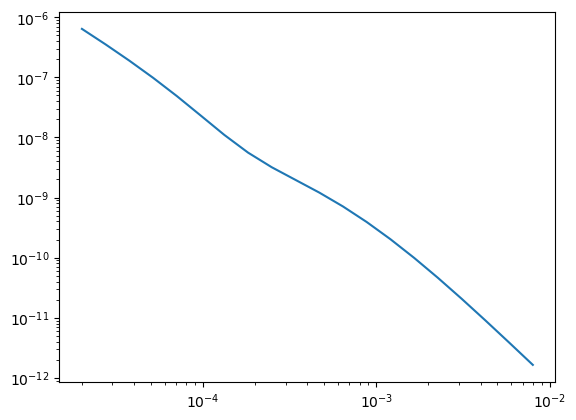

In [116]:
plt.loglog(rx_times, -dobs)

In [95]:
def setup_inversion(norms=[0, 0]): 
    dmis = data_misfit.L2DataMisfit(simulation=sim1d, data=data_invert)
    reg = regularization.Sparse(
        mesh_invert, alpha_s=0.1, alpha_x=1.0, 
        reference_model=np.log(1./rho_back),
        norms=norms
    )

    opt = optimization.InexactGaussNewton(maxIter=30, tolCG=1e-3)
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)
    
    # Defining a starting value for the trade-off parameter (beta) between the data
    # misfit and the regularization.
    starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e1)

    # Update the preconditionner
    update_Jacobi = directives.UpdatePreconditioner()

    # Options for outputting recovered models and predicted data for each beta.
    save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

    # Directives for the IRLS
    update_IRLS = directives.Update_IRLS(
        max_irls_iterations=30, minGNiter=1, coolEpsFact=1.5, update_beta=True
    )

    # Updating the preconditionner if it is model dependent.
    update_jacobi = directives.UpdatePreconditioner()

    # Add sensitivity weights
    sensitivity_weights = directives.UpdateSensitivityWeights()

    # The directives are defined as a list.
    directives_list = [
        sensitivity_weights,
        starting_beta,
        save_iteration,
        update_IRLS,
        update_jacobi,
    ]
    
    # Here we combine the inverse problem and the set of directives
    inv = inversion.BaseInversion(inv_prob, directives_list)
    
    return inv

In [96]:
invl1 = setup_inversion([1, 1])
# Run the inversion
starting_model = np.log(1./rho_back)*np.ones(mesh_invert.n_cells)
recovered_model_l1 = invl1.run(starting_model)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.09e+03  6.52e+02  0.00e+00  6.52e+02    1.37e+02      0              
   1  2.05e+03  5.81e+02  7.35e-03  5.96e+02    8.72e+01      0              
   2  1.02e+03  4.60e+02  4.77e-02  5.09e+02    6.67e+01      0   Skip BFGS  
   3  5.12e+02  3.35e+02  1.55e-01  4.14e+02    6.27e+01      0   Skip BFGS  
   4  2.56e+02  2.00e+02  4.07e-01  3.04e+02    5.34e+01      0   Skip BFGS  
   5  1.28e+02  1.01e+02  8.04e-01  2.04e+02    4.04e+01      0   Skip BFGS  
   6  6.40e+01  4.70e+01  1.27e+0

In [99]:
invl0 = setup_inversion([0, 0])
recovered_model_l0 = invl0.run(starting_model)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.77e+03  6.52e+02  0.00e+00  6.52e+02    1.37e+02      0              
   1  2.39e+03  5.92e+02  5.31e-03  6.05e+02    8.84e+01      0              
   2  1.19e+03  4.83e+02  3.60e-02  5.26e+02    6.72e+01      0   Skip BFGS  
   3  5.97e+02  3.65e+02  1.21e-01  4.37e+02    6.39e+01      0   Skip BFGS  
   4  2.98e+02  2.28e+02  3.36e-01  3.28e+02    5.59e+01      0   Skip BFGS  
   5  1.49e+02  1.19e+02  7.08e-01  2.24e+02    4.34e+01      0   Skip BFGS  
   6  7.46e+01  5.60e+01  1.16e+0

In [ ]:
invl0.

Text(0.5, 0, 'conductivity (S/m)')

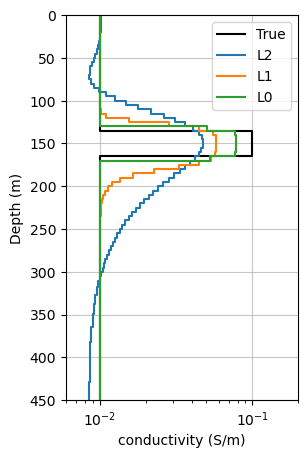

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(3, 5))

plot_1d_layer_model(sim1d_true.thicknesses, np.exp(m_true), ax=ax, color="k", label="True")
plot_1d_layer_model(mesh_invert.h[0], np.exp(invl0.invProb.l2model), ax=ax, label="L2")
plot_1d_layer_model(mesh_invert.h[0], np.exp(recovered_model_l1), ax=ax, label="L1")
plot_1d_layer_model(mesh_invert.h[0], np.exp(recovered_model_l0), ax=ax, label="L0")

ax.set_ylim([450, 0])
ax.set_xlim([6e-3, 2e-1])
ax.grid("both", alpha=0.7)
ax.legend()

ax.set_xlabel("conductivity (S/m)")

Text(0, 0.5, 'db/dt')

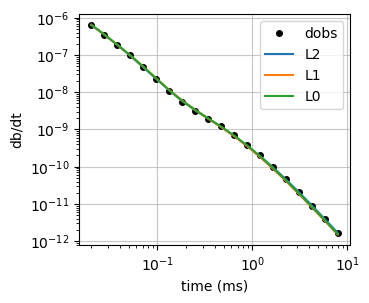

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))

ax.loglog(rx_times*1e3, -dobs, "ko", label="dobs", ms=4)
ax.loglog(rx_times*1e3, -sim1d.dpred(invl0.invProb.l2model), label="L2")
ax.loglog(rx_times*1e3, -sim1d.dpred(recovered_model_l1), label="L1")
ax.loglog(rx_times*1e3, -sim1d.dpred(recovered_model_l0), label="L0")

ax.legend()
ax.grid("both", alpha=0.7)
ax.set_xlabel("time (ms)")
ax.set_ylabel("db/dt")